<a href="https://colab.research.google.com/github/yue-sun/generative-art/blob/d2_space_filling/02_tuesday/02_space_filling_curves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Continuous line drawing with space-filling curves

![Continuous-line-drawing](https://raw.githubusercontent.com/yue-sun/generative-art/d2_space_filling/02_tuesday/figs/continuous_line_drawing.png)

Space-filling curves are a type of fractal that can fill the 2D plane. Notably, space-filling curves have finite area, but infinite length. Here we will look at a particular type of space-filling curve, the Hilbert curve, and see how we can use it to make continuous line drawings. The figure below illustrates the first four levels of the Hilbert curve on a regular grid.

![Hilbert-curve](https://raw.githubusercontent.com/yue-sun/generative-art/d2_space_filling/02_tuesday/figs/hilbert_curve.png)

A good way to think about the Hilbert curve is that it provides a mapping between an $(x,y)$ coordinate in 2D and a corresponding numeric label. This mapping gives us a unique traversal order through the grid points, as shown below:

![Hilbert-curve-labeled](https://raw.githubusercontent.com/yue-sun/generative-art/d2_space_filling/02_tuesday/figs/hilbert_curve_labeled.png)

Let's look at how this mapping can be determined in more detail. The following figure shows an iterative approach by which the numeric label for a given $(x,y)$ coordinate can be determined, down to the 3rd level of refinement. The key steps are as follows:
1. Starting with the most significant bits, begin determining the numeric index by identifying the quadrant in which the point lies.
2. To begin the next iteration, adjust the origin to the center of the current quadrant, and define new quadrants with half the size.
3. Determine the next pair of digits.
4. Adjust the origin to the center of the current quadrant.
5. If the previous iteration ended in one of the lower two quadrants, perform a reflection about the line $y=x$ (lower left) or $y=-x$ (lower right) relative to the newly-centered axes.

![Hilbert-process](https://raw.githubusercontent.com/yue-sun/generative-art/d2_space_filling/02_tuesday/figs/hilbert_process.png)

Let's see this in code:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# map a coordinate to its corresponding linear index based on the Hilbert
# space-filling curve.
def coord2index(x,y,lv):
    # (x,y) is the coordinate to map
    # lv sets the grid resolution and number of digits to allow for the
    # index; indices will range from 0 to 4^lv-1.
    # assume the coordinate is confined to the square [-1,1]x[-1,1].
    d=0.5
    i=0
    # number of digits in binary is 2*lv.
    for j in range(lv):
        # bit shift by 2; more significant bits are handled first
        i<<=2
        
        # update the bits
        if x<0 and y<0:     i|=0  # (00)
        elif x<0 and y>=0:  i|=1  # (01)
        elif x>=0 and y>=0: i|=2  # (10)
        else:               i|=3  # (11)
            
        # update quadrant centers
        if x>0: x-=d
        else:   x+=d
        if y>0: y-=d
        else:
            y+=d
            # apply a reflection to the lower two quadrants
            # to set up for next iteration
            tmp=y
            y=-x if i&1 else x
            x=-tmp if i&1 else tmp
            
        # rescale
        d*=0.5
    return i

While we traditionally see the Hilbert curve on a grid, this mapping gives us a traversal order through any set of points in 2D. Provided the domain is subdivided far enough, we can obtain a unique label for each point, then connect them in order of smallest to largest, even if the numeric labels are not necessarily consecutive.

![Hilbert-examples](https://raw.githubusercontent.com/yue-sun/generative-art/d2_space_filling/02_tuesday/figs/hilbert_examples.png)

With this idea in mind, let's apply the Hilbert space-filling curve to create continuous line drawings! First, we create a helper function that takes a collection of points, rescales them to a maximal extent of $[-1,1]$, and computes and returns consecutive indices to use in traversing a path through the points based on the Hilbert space-filling curve.

In [2]:
# Return consecutive indices for a set of points.
def get_hilbert_indices(pts,lv=12):
    # Map the coordinates onto a region with maximal extent [-1,1].
    hi = np.max(pts)
    lo = np.min(pts)
    pts = 2*(pts-lo)/(hi-lo)-1
    x = pts[:,0]
    y = pts[:,1]

    # Get the (possibly non-consecutive) indices for the points.
    inds = np.zeros(len(pts))
    for i,(xx,yy) in enumerate(zip(x,y)):
        inds[i] = coord2index(xx,yy,lv)

    # Return sequential indices using argsort.
    return np.argsort(inds)

Next we define routines for loading, downsampling, and plotting an image.

In [3]:
from skimage.io import imread
from skimage.measure import block_reduce

def load_image(img_path, max_size=500):   
    im = imread(img_path, as_gray=True)

    # ensure image is on [0,255].
    if np.max(im) < 2:
        im *= 255.

    # downsample the image a bit if it's too big.
    m,n = im.shape
    while max(m,n) > max_size:
        im = block_reduce(im, block_size=(2,2), func=np.mean, cval=255.)
        m,n = im.shape
    print("Image dimensions:",m,n)
    return im

def image_plot(figsize=(7,7)):
    plt.close()
    fig, ax = plt.subplots(1,1,figsize=figsize)
    ax.axis('equal')
    ax.axis('off')
    fig.tight_layout()
    return fig, ax

Let's look at a test image below.

Image dimensions: 251 251


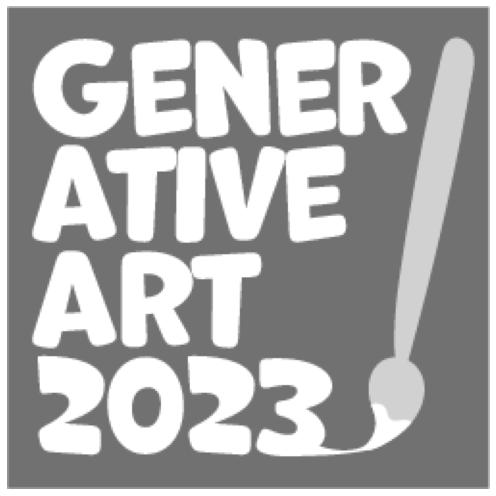

In [4]:
# Load a test image
im = load_image("https://raw.githubusercontent.com/yue-sun/generative-art/d2_space_filling/02_tuesday/samples/gen_art.png")
m,n = im.shape

fig, ax = image_plot()
ax.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.show()

What we'd like to do is sample this image based on intensity: Dark regions are sampled more often, and light regions less often. A procedure for this is described in the following paper, which we'll use as our basis for sampling:

>Bosch, R., & Herman, A. Continuous line drawings via the traveling salesman problem. Operations research letters, 32(4), 302-303 (2004)
https://doi.org/10.1016/j.orl.2003.10.001.

In fact, this paper demonstrates how to perform continuous line drawings through a different approach, by solving the Traveling Salesman Problem.

The key steps in the sampling process are:
1. Subdivide the image into blocks of size $bls \times bls$.
2. For each block $(i,j)$, compute the average intensity (grayscale value) $\mu_{ij}$.
3. For each block $(i,j)$, compute the number of samples $g_{ij}$ to take within that block based on its average intensity. We will use the formula

$$
g_{ij} = \gamma - \lfloor \gamma\left(\frac{\mu_{ij}}{256}\right)^{\beta} \rfloor
$$

where $\gamma$ is an integer that adjusts the number of levels of different sampling density, and $\beta$ adjusts the contrast between dark and light.

4. For each block $(i,j)$, sample $g_{ij}$ points uniformly inside the 2D region corresponding to that block.

In [5]:
# Subdivide image into blsxbls blocks (i,j), and sample g_ij points in each block based on intensity.
def sample_image(im, bls=3, gamma=20, beta=1.):
    # compute the mean value of each block.
    mu = block_reduce(im, block_size=(bls,bls), func=np.mean,
                      cval=np.mean(np.hstack([im[:,-1],im[-1,:]])))
    m, n = mu.shape
    
    # calculate number of samples to make in each block.
    g = gamma - np.floor(gamma*(mu/256)**beta).astype(int)
    
    # Sample g(i,j) points uniformly in each bls*bls block (i,j).
    N = np.sum(g) # total number of points to sample
    print("Number of points:",N)
    x = np.zeros(N)
    y = np.zeros(N)
    k = 0
    for i in range(m):
        for j in range(n):
            xs = np.random.uniform(low=j, high=j+1, size=g[i,j])
            ys = np.random.uniform(low=m-i-1, high=m-i, size=g[i,j])
            x[k:k+g[i,j]] = xs
            y[k:k+g[i,j]] = ys
            k += g[i,j]
        
    pts = np.unique(np.c_[x,y], axis=0)
    bounds = (0,n,0,m)
    return pts, bounds

Let's sample our test image using a block size of 3.

Number of points: 54469


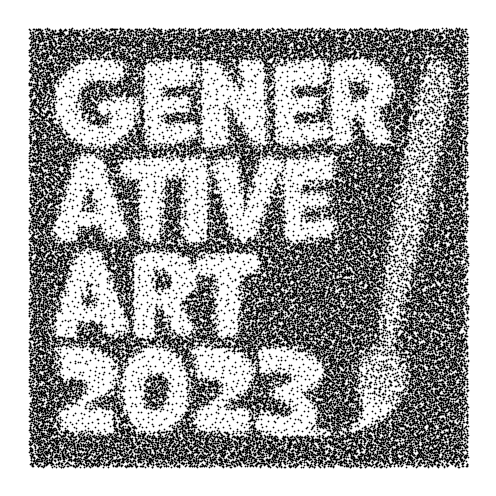

In [6]:
bls = 3
pts, bounds = sample_image(im, bls)

fig, ax = image_plot()
ax.scatter(pts[:,0], pts[:,1], s=0.5, color='k')
plt.show()

With the collection of points to traverse, we can now obtain the Hilbert indices and plot our continuous line drawing!

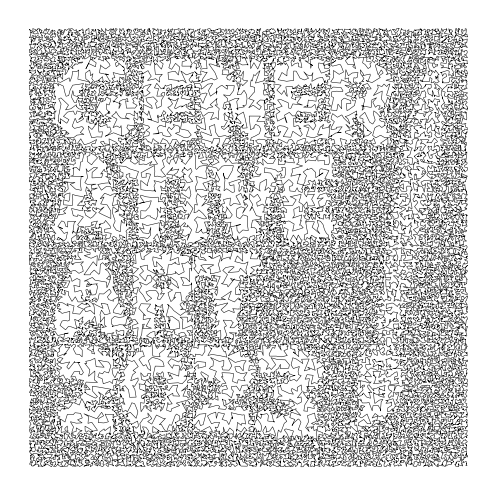

In [7]:
inds = get_hilbert_indices(pts)

# use indices to reorder x and y in correct traversal order by index.
x = pts[inds,0]
y = pts[inds,1]

fig, ax = image_plot()
ax.plot(x, y, lw=0.5, color='k')
plt.show()

This works as expected, but it can be improved. For example, notice how the points are not so evenly spaced, and the resulting line is jittery. Can we do something to regularize the spacing?

One approach we can use follows from Voronoi tessellations. Given a set of points and the corresponding [Voronoi tessellation](https://en.wikipedia.org/wiki/Voronoi_diagram), we can use a very simple procedure known as [Lloyd's algorithm](https://en.wikipedia.org/wiki/Lloyd%27s_algorithm) to smooth the spacing of points. Lloyd's algorithm works by iteratively moving each point to the centroid of its Voronoi cell, then recomputing the Voronoi diagram. Over time, the Voronoi tessellation approaches a centroidal Voronoi tessellation, in which the points coincide with their cell centroids. The effects of Lloyd's algorithm on a small set of points is illustrated below.
![Voronoi-Lloyd](https://raw.githubusercontent.com/yue-sun/generative-art/d2_space_filling/02_tuesday/figs/voronoi_lloyd.png)

We can use the Voronoi package from scipy.spatial to compute the Voronoi diagram. A bit of extra care is needed to ensure the boundaries of the domain are rectangular. This involves appending mirrored versions of the boundary points across their nearest edge to obtain straight Voronoi cell boundaries, and is handled by the following routine ```bounded_voronoi```.

In [8]:
from scipy.spatial import Voronoi

# Compute a Voronoi diagram with rectangular bounds.
def bounded_voronoi(pts, bounds):
    # create the initial Voronoi diagram.
    vor = Voronoi(pts, incremental=True)

    # find vertices that lie outside the bounded domain, and store their index.
    # Also include -1, which is scipy's flag for a vertex outside the Voronoi diagram.
    out_vert_ids = [-1]+[i for i,v in enumerate(vor.vertices) if not in_bounds(v, bounds)]

    # identify which points have cell vertices outside the domain, and store their index.
    bound_ids = [i for i,r in enumerate(vor.point_region)
                 if any(v in out_vert_ids for v in vor.regions[r])]

    # mirror the boundary points and add them to the diagram. This makes the cells of
    # all our original points bounded in the rectangular domain.
    pts_add = mirror_points(pts[bound_ids,:], bounds)
    vor.add_points(pts_add)
    return vor

def mirror_points(pts, bounds):
    # inspired by: https://stackoverflow.com/questions/28665491/getting-a-bounded-polygon
    #-coordinates-from-voronoi-cells.
    # mirror the points over the boundaries of the bounding box to obtain bounded
    # polygons for all voronoi cells of interest.
    xmin, xmax, ymin, ymax = bounds
    xmid = 0.5*(xmin+xmax)
    ymid = 0.5*(ymin+ymax)
    pts_n = np.copy(pts[pts[:,1]>ymid]); pts_s = np.copy(pts[pts[:,1]<ymid])
    pts_e = np.copy(pts[pts[:,0]>xmid]); pts_w = np.copy(pts[pts[:,0]<xmid])
    pts_n[:,1] = ymax+(ymax-pts_n[:,1])
    pts_s[:,1] = ymin-(pts_s[:,1]-ymin)
    pts_e[:,0] = xmax+(xmax-pts_e[:,0])
    pts_w[:,0] = xmin-(pts_w[:,0]-xmin)
    pts_c = np.vstack([pts_n,pts_s,pts_e,pts_w])
    return pts_c

def in_bounds(pt, bounds):
    xmin, xmax, ymin, ymax = bounds
    return (xmin <= pt[0] <= xmax) and (ymin <= pt[1] <= ymax)

Finally we set up a function to iteratively compute the Voronoi diagram, then adjust the point coordinates to their cooresponding cell centroids.

In [9]:
from numba import njit

# Converge to a centroidal voronoi diagram.
def centroidal_voronoi(pts, bounds, iters=1):
    N = len(pts) # the number of points to adjust.
    for k in range(iters):
        vor = bounded_voronoi(pts, bounds)
        
        # find the polygons corresponding to the original points' Voronoi cells. Each
        # polygon is represented by a list of vertex coordinates, with the last matching
        # the first to form a closed loop. To use njit, we will need to unravel the list
        # of lists of vertex ids and use a pointer to indicate the start of each new
        # polygon's vertex set.
        vert_ids = [vor.regions[r]+[vor.regions[r][0]] for r in vor.point_region[:N]]
        vert_ptr = np.cumsum(np.array([0]+[len(verts) for verts in vert_ids]))
        vert_ids = np.array([v for verts in vert_ids for v in verts])
        vert_pos = np.array(vor.vertices)
        
        # update the current set of points to the centroids of the cells.
        pts = get_centroids(vert_ids, vert_ptr, vert_pos)
    return pts

@njit
def centroid(pts):
    # compute the centroid of a closed polygon with coordinates given by pts.
    # the first and last coordinates should be the same.
    area=0; c=np.zeros(2)
    for i in range(len(pts)-1):
        s = pts[i,0]*pts[i+1,1]-pts[i+1,0]*pts[i,1]
        area += s
        c+=s*(pts[i]+pts[i+1])
    c /= 3*area
    return c

@njit
def get_centroids(vert_ids, vert_ptr, vert_pos):
    N = len(vert_ptr)-1
    centroids = np.zeros((N,2))
    for i in range(N):
        verts = vert_ids[vert_ptr[i]:vert_ptr[i+1]]
        pos = vert_pos[verts]
        centroids[i] = centroid(pos)
    return centroids

Let's see how this works on our existing coordinate set:

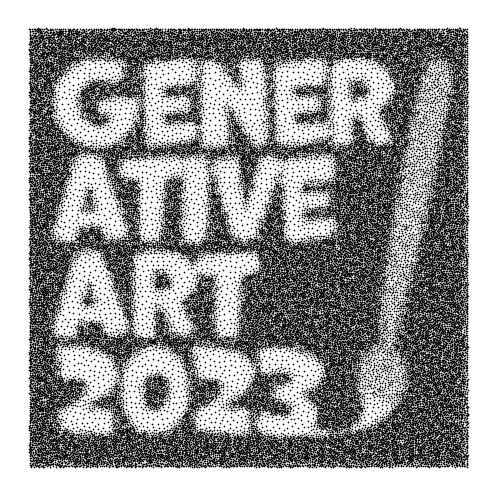

CPU times: user 15.7 s, sys: 565 ms, total: 16.3 s
Wall time: 16.2 s


In [10]:
%%time

pts = centroidal_voronoi(pts, bounds, 2)

fig, ax = image_plot()
ax.scatter(pts[:,0], pts[:,1], s=0.5, color='k')
plt.show()

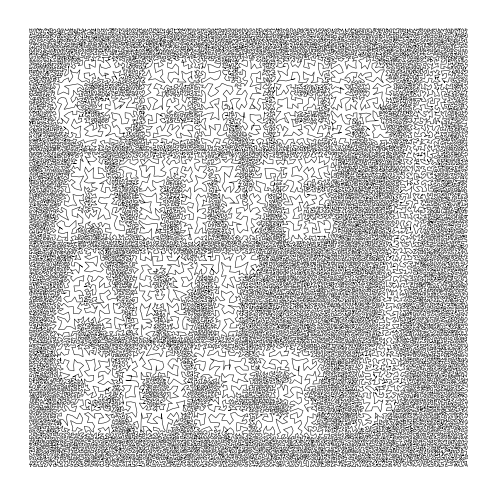

In [11]:
inds = get_hilbert_indices(pts)

# use indices to reorder x and y in correct traversal order by index.
x = pts[inds,0]
y = pts[inds,1]

fig, ax = image_plot()
ax.plot(x, y, lw=0.5, color='k')
plt.show()

Finally, we can experiment with some famous art!

Image dimensions: 300 300


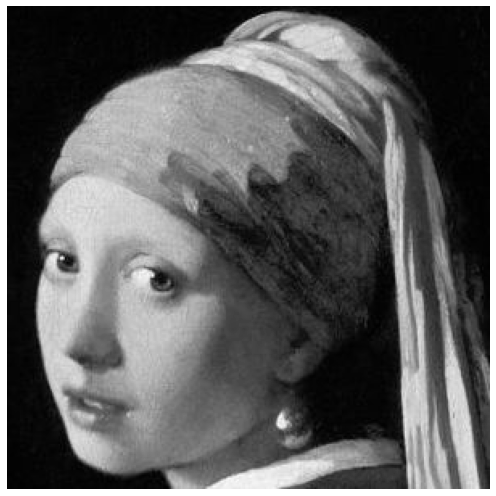

In [12]:
# load in an image.
im = load_image("https://raw.githubusercontent.com/yue-sun/generative-art/d2_space_filling/02_tuesday/samples/girl_with_pearl_earring.jpg")
m, n = im.shape

plt.close()
fig, ax = image_plot()
ax.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.show()

In [13]:
%%time

# sample the image.
bls = 3
pts, bounds = sample_image(im, bls, gamma=20, beta=1./4)

# smooth.
pts = centroidal_voronoi(pts, bounds, 2)

# find drawing path.
inds = get_hilbert_indices(pts)

# define x and y in traversal order.
x = pts[inds,0]
y = pts[inds,1]

Number of points: 67212
CPU times: user 20.6 s, sys: 276 ms, total: 20.9 s
Wall time: 21.5 s


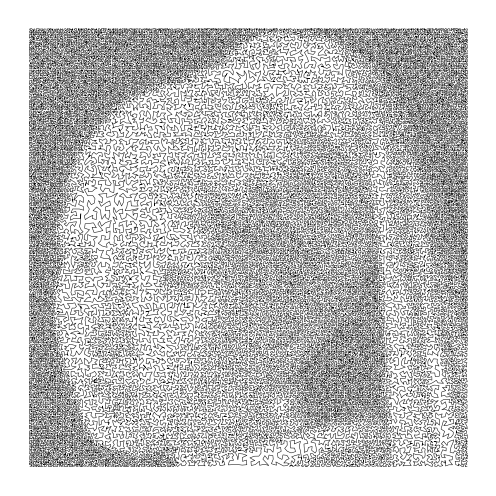

In [14]:
# plot.
fig, ax = image_plot()
ax.plot(x, y, lw=0.5, color='k')
plt.show()

We can also vary the line color, for example by segment length.

In [15]:
from matplotlib.collections import LineCollection

points = np.array([x,y]).T.reshape(-1,1,2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lengths = np.array([np.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2) for p1,p2 in zip(segments[:,0,:],segments[:,1,:])])
lengths = np.log(lengths)

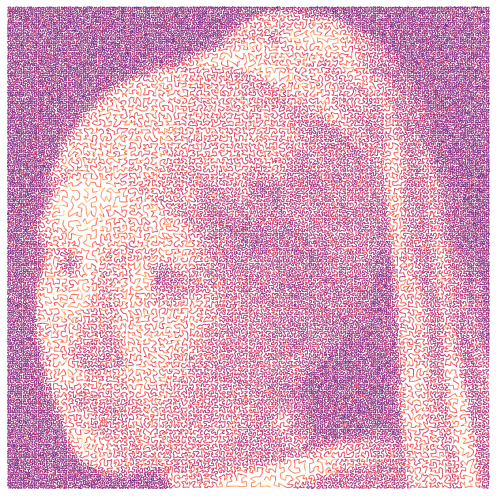

In [16]:
plt.close()
fig, ax = image_plot()
lc = LineCollection(segments, array=lengths, cmap=plt.cm.magma, linewidth=1)
ax.add_collection(lc)
ax.set_xlim(bounds[:2])
ax.set_ylim(bounds[2:])
plt.show()

### Your turn!
Try using a different image of your choice to create a continuous line drawing. Some tips for successful drawing:
- Images with high contrast elements work best.
- The centroidal Voronoi step can take a while, especially for a large number of points. Experiment with the desired settings by initially excluding this step, then turn it back on when you're ready to refine.
- Sometimes the centroidal Voronoi can hit a snag if we try to add a point that closely coincides with an existing one. If this occurs, you can re-run the sampling to get a different random set of points. However, this should not happen very often.